In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from tqdm.auto import tqdm

In [8]:
DATASET_PATH = "/Users/jeremy/Google Drive/datasets/fashion-dataset/"

In [9]:
df = pd.read_csv(DATASET_PATH + "styles_preprocessed.csv", error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df

id gender masterCategory subCategory            articleType  \
0      15970    Men        Apparel     Topwear                 Shirts   
1      39386    Men        Apparel  Bottomwear                  Jeans   
2      59263  Women    Accessories     Watches                Watches   
3      21379    Men        Apparel  Bottomwear            Track Pants   
4      53759    Men        Apparel     Topwear                Tshirts   
...      ...    ...            ...         ...                    ...   
44434  17036    Men       Footwear       Shoes           Casual Shoes   
44435   6461    Men       Footwear  Flip Flops             Flip Flops   
44436  18842    Men        Apparel     Topwear                Tshirts   
44437  46694  Women  Personal Care   Fragrance  Perfume and Body Mist   
44438  51623  Women    Accessories     Watches                Watches   

      baseColour  season    year   usage  \
0      Navy Blue    Fall  2011.0  Casual   
1           Blue  Summer  2012.0  Casual   
2         Silver  Winter  2016.0  Casual   
3          Black    Fall  2011.0  Casual   
4           Grey  Summer  2012.0  Casual   
...          ...     ...     ...     ...   
44434      White  Summer  2013.0  Casual   
44435        Red  Summer  2011.0  Casual   
44436       Blue    Fall  2011.0  Casual   
44437       Blue  Spring  2017.0  Casual   
44438       Pink  Winter  2016.0  Casual   

                                    productDisplayName      image  
0                     Turtle Check Men Navy Blue Shirt  15970.jpg  
1                   Peter England Men Party Blue Jeans  39386.jpg  
2                             Titan Women Silver Watch  59263.jpg  
3        Manchester United Men Solid Black Track Pants  21379.jpg  
4                                Puma Men Grey T-shirt  53759.jpg  
...                                                ...        ...  
44434                        Gas Men Caddy Casual Shoe  17036.jpg  
44435               Lotto Men's Soccer Track Flip Flop   6461.jpg  
44436             Puma Men Graphic Stellar Blue Tshirt  18842.jpg  
44437                   Rasasi Women Blue Lady Perfume  46694.jpg  
44438  Fossil Women Pink Dial Chronograph Watch ES3050  51623.jpg  

[44439 rows x 11 columns]

In [10]:
# Load ResNet-50 model pretrained on Imagenet without the classifying layers on top.
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [11]:
def get_img_path(img):
  return DATASET_PATH + "images/" + img

In [12]:
def extract_embeddings(img_name, model):
  input_shape = (224, 224, 3)
  img = image.load_img(get_img_path(img_name), target_size=(input_shape[0], input_shape[1]))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0)
  preprocessed_img = preprocess_input(expanded_img_array)
  embeddings = model.predict(preprocessed_img)
  return embeddings.reshape(-1)

In [17]:
tqdm.pandas()

In [19]:
# Create embeddings and store them into dataframe
map_embeddings = df['image'].progress_map(lambda img: extract_embeddings(img, model))
df_embs        = map_embeddings.apply(pd.Series)

100%|██████████| 44439/44439 [2:18:02<00:00,  5.37it/s]


In [21]:
df_embs.to_pickle(DATASET_PATH + "resnet50-embeddings-full.pkl")

In [22]:
num_feature_dimensions = 2  # Set the number of embedding dimensions
pca = PCA(n_components = num_feature_dimensions)
embs_compressed = pca.fit_transform(df_embs)
df_embs_compressed = pd.DataFrame(embs_compressed)
df_embs_compressed

0           1
0     -104.751099  -37.234646
1      -94.060829  -39.800789
2       29.836599  102.058090
3      -79.614845  -21.048717
4     -103.115936  -31.121609
...           ...         ...
44434  107.396973  -46.281178
44435  123.991936  -65.192497
44436 -108.835800  -24.313913
44437   46.208534   60.389336
44438   39.031422  117.654312

[44439 rows x 2 columns]

In [24]:
df['x'] = df_embs_compressed[0]
df['y'] = df_embs_compressed[1]

<AxesSubplot:xlabel='x', ylabel='y'>

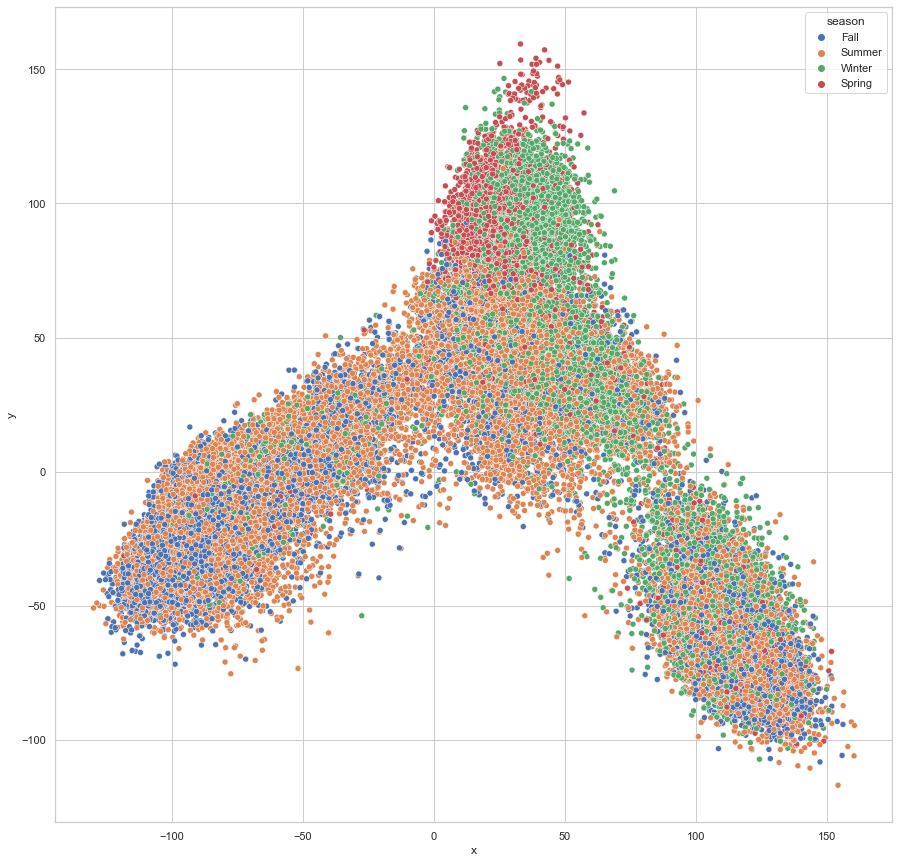

In [33]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(x="x", y="y", 
                hue="season", data=df, 
                legend="full")